# Penjelasan Code2

### 1. Import Library
- **pandas**: digunakan untuk manipulasi dan analisis data.
- **sqlalchemy**: digunakan untuk membuat koneksi ke database SQL.
- **pycaret.clustering & pycaret.anomaly**: modul dari PyCaret untuk melakukan analisis clustering dan deteksi anomali.

### 2. Konfigurasi Koneksi Database
```python
db_user = 'user'
db_password = 'password'
db_host = 'localhost'
db_port = '5432'
db_name = 'iris_data'
table_name = 'iris_data'


## Instalasi Library yang Dibutuhkan

In [1]:
# Jalankan sel ini untuk menginstal semua library yang dibutuhkan
%pip install pycaret[full] psycopg2-binary sqlalchemy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


##  Import Library dan Koneksi ke Database PostgreSQL

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import os

# --- GANTI DENGAN DETAIL DATABASE ANDA ---
db_user = 'postgres'
db_password = '123456789'
db_host = 'localhost'  # atau alamat IP server database Anda
db_port = '5432'
db_name = 'iris_data'
table_name = 'iris_data'
# -----------------------------------------

# Membuat koneksi string untuk SQLAlchemy
db_uri = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Memuat data dari PostgreSQL ke dalam DataFrame pandas
try:
    print("Menghubungkan ke database...")
    engine = create_engine(db_uri)
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, engine)
    print("Data berhasil dimuat!")
    print("Berikut adalah 5 baris pertama dari data Anda:")
    display(df.head())
except Exception as e:
    print(f"Terjadi kesalahan saat menghubungkan atau mengambil data: {e}")

Menghubungkan ke database...


Data berhasil dimuat!
Berikut adalah 5 baris pertama dari data Anda:


,id,Class,sepal length,sepal width,petal length,petal width
0,1,Iris-setosa,5.1,3.5,1.4,0.2
1,2,Iris-setosa,4.9,3.0,1.4,0.2
2,3,Iris-setosa,4.7,3.2,1.3,0.2
3,4,Iris-setosa,4.6,3.1,1.5,0.2
4,5,Iris-setosa,5.0,3.6,1.4,0.2


## Setup Environment PyCaret untuk Deteksi Anomali

In [3]:
from pycaret.anomaly import *

# Inisialisasi environment PyCaret untuk deteksi anomali
# Ganti 'silent=True' dengan 'verbose=False'
print("Menyiapkan environment PyCaret untuk deteksi anomali...")
anomaly_setup = setup(data=df, session_id=123, verbose=False)
print("Setup selesai.")

Menyiapkan environment PyCaret untuk deteksi anomali...


## Membuat Model Deteksi Outlier KNN

In [4]:
# Membuat model K-Nearest Neighbors (KNN) untuk deteksi outlier
print("Membuat model KNN...")
knn_model = create_model('knn')
print("Model KNN berhasil dibuat:")
print(knn_model)

Membuat model KNN...


Model KNN berhasil dibuat:
KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)


## Memberi Label Outlier pada Data

In [5]:
# Menggunakan model untuk melabeli data
results_anomaly = assign_model(knn_model)

print("Data setelah diberi label outlier:")
display(results_anomaly.head())

# Menghitung jumlah inlier dan outlier yang ditemukan
print("\nJumlah Inlier (0) dan Outlier (1):")
print(results_anomaly['Anomaly'].value_counts())

Data setelah diberi label outlier:


,id,Class,sepal length,sepal width,petal length,petal width,Anomaly,Anomaly_Score
0,1,Iris-setosa,5.1,3.5,1.4,0.2,1,5.037857
1,2,Iris-setosa,4.9,3.0,1.4,0.2,1,4.146083
2,3,Iris-setosa,4.7,3.2,1.3,0.2,0,3.190611
3,4,Iris-setosa,4.6,3.1,1.5,0.2,0,3.018278
4,5,Iris-setosa,5.0,3.6,1.4,0.2,0,3.008322



Jumlah Inlier (0) dan Outlier (1):
Anomaly
0    142
1      8
Name: count, dtype: int64


## Visualisasi Hasil Deteksi Outlier

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor # Model deteksi outlier yang mirip KNN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

In [23]:
# --- Langkah 1: Mempersiapkan Data dan Model ---

# Membuat data contoh: 300 titik data normal dan 20 titik outlier
# 'make_blobs' membuat gerombolan data yang bagus untuk visualisasi
X_normal, y_normal = make_blobs(n_samples=300, centers=2, cluster_std=1.5, random_state=42)

# Menambahkan beberapa titik outlier yang jauh dari gerombolan utama
rng = np.random.RandomState(42)
X_outliers = rng.uniform(low=-10, high=10, size=(20, 2))

# Menggabungkan data normal dan outlier
X = np.vstack([X_normal, X_outliers])
# Membuat label: 0 untuk data normal (inlier), 1 untuk data aneh (outlier)
# Ini adalah "jawaban" yang sebenarnya, kita akan lihat apakah model bisa menemukannya
y_true = np.hstack([np.zeros(len(X_normal)), np.ones(len(X_outliers))])

# Normalisasi data sangat direkomendasikan sebelum t-SNE dan model outlier
X_scaled = StandardScaler().fit_transform(X)

# Membuat dan melatih model deteksi outlier (mirip dengan model KNN Anda)
# 'LocalOutlierFactor' bekerja dengan membandingkan kepadatan lokal suatu titik dengan tetangganya
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.1) # Asumsi 10% data adalah outlier
y_pred = lof_model.fit_predict(X_scaled)

# Mengubah hasil prediksi menjadi format yang lebih mudah dibaca
# Model ini memberi label -1 untuk outlier dan 1 untuk inlier, kita ubah ke 1 dan 0
outlier_labels = pd.Series(y_pred).apply(lambda x: 1 if x == -1 else 0)


In [24]:
# --- Langkah 2: Menjalankan t-SNE ---

# t-SNE akan mengubah data kita dari banyak fitur menjadi hanya 2 (koordinat x dan y)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Menggabungkan hasil t-SNE dengan label outlier ke dalam satu DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=['x_tsne', 'y_tsne'])
df_tsne['Status'] = outlier_labels.apply(lambda x: 'Outlier (Terdeteksi)' if x == 1 else 'Normal')

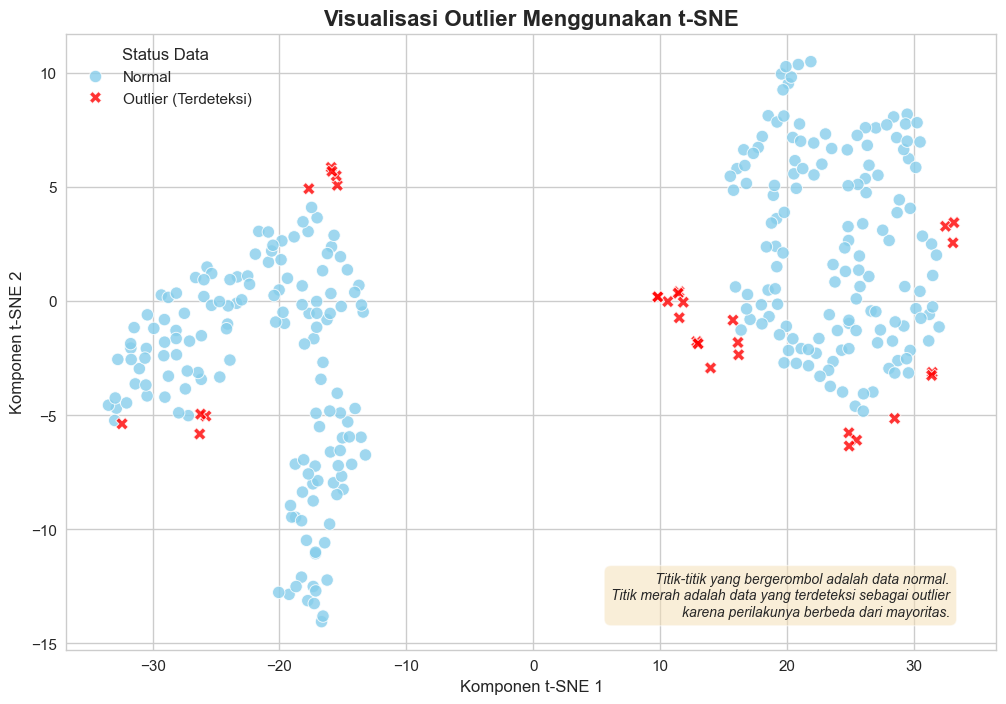

In [25]:
# --- Langkah 3: Membuat Visualisasi yang Lebih Mudah Dipahami ---

plt.style.use('seaborn-v0_8-whitegrid') # Menggunakan style plot yang bagus
plt.figure(figsize=(12, 8)) # Mengatur ukuran gambar agar lebih besar

# Membuat scatter plot menggunakan Seaborn
# 'hue' akan secara otomatis mewarnai titik berdasarkan kolom 'Status'
# 'palette' mengatur warna yang akan digunakan
# 'style' memberikan bentuk yang berbeda untuk setiap status
sns.scatterplot(
    data=df_tsne,
    x='x_tsne',
    y='y_tsne',
    hue='Status',
    style='Status',
    palette={'Normal': 'skyblue', 'Outlier (Terdeteksi)': 'red'},
    s=80, # Ukuran titik
    alpha=0.8 # Transparansi titik
)

# Menambahkan judul dan label yang jelas
plt.title('Visualisasi Outlier Menggunakan t-SNE', fontsize=16, fontweight='bold')
plt.xlabel('Komponen t-SNE 1', fontsize=12)
plt.ylabel('Komponen t-SNE 2', fontsize=12)
plt.legend(title='Status Data', loc='best') # Menampilkan legenda

# Menambahkan teks penjelasan langsung di plot
plt.text(0.95, 0.05,
         'Titik-titik yang bergerombol adalah data normal.\nTitik merah adalah data yang terdeteksi sebagai outlier\nkarena perilakunya berbeda dari mayoritas.',
         fontsize=10,
         style='italic',
         ha='right', # Rata kanan
         va='bottom', # Rata bawah
         transform=plt.gca().transAxes, # Posisi relatif terhadap axes plot
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.show() # Menampilkan plot


## Setup Environment PyCaret untuk Clustering

In [8]:
from pycaret.clustering import *

# Inisialisasi environment PyCaret untuk clustering
# Ganti 'silent=True' dengan 'verbose=False'
print("Menyiapkan environment PyCaret untuk clustering...")
clustering_setup = setup(data=df, session_id=456, verbose=False)
print("Setup selesai.")

Menyiapkan environment PyCaret untuk clustering...
Setup selesai.


## Membuat Model Clustering K-Means

In [9]:
# Membuat model K-Means dengan 4 cluster
print("Membuat model K-Means...")
kmeans_model = create_model('kmeans', num_clusters=4)
print("Model K-Means berhasil dibuat:")
print(kmeans_model)

Membuat model K-Means...


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5560,717.9069,0.5092,0,0,0


Model K-Means berhasil dibuat:
KMeans(n_clusters=4, random_state=456)


## Memberi Label Cluster pada Data

In [10]:
# Menambahkan label cluster ke data asli
results_cluster = assign_model(kmeans_model)

print("Data setelah diberi label cluster:")
display(results_cluster.head())

# Menghitung jumlah anggota di setiap cluster
print("\nJumlah data per cluster:")
print(results_cluster['Cluster'].value_counts())

Data setelah diberi label cluster:


,id,Class,sepal length,sepal width,petal length,petal width,Cluster
0,1,Iris-setosa,5.1,3.5,1.4,0.2,Cluster 3
1,2,Iris-setosa,4.9,3.0,1.4,0.2,Cluster 3
2,3,Iris-setosa,4.7,3.2,1.3,0.2,Cluster 3
3,4,Iris-setosa,4.6,3.1,1.5,0.2,Cluster 3
4,5,Iris-setosa,5.0,3.6,1.4,0.2,Cluster 3



Jumlah data per cluster:
Cluster
Cluster 2    40
Cluster 1    38
Cluster 3    36
Cluster 0    36
Name: count, dtype: int64


## Visualisasi Hasil Clustering

In [11]:
# Visualisasi 2D dari cluster yang terbentuk
# Plot ini mengurangi dimensi data (biasanya dengan PCA) untuk menampilkannya dalam 2D
plot_model(kmeans_model, plot='cluster')

## Visualisasi Tambahan untuk Evaluasi Cluster

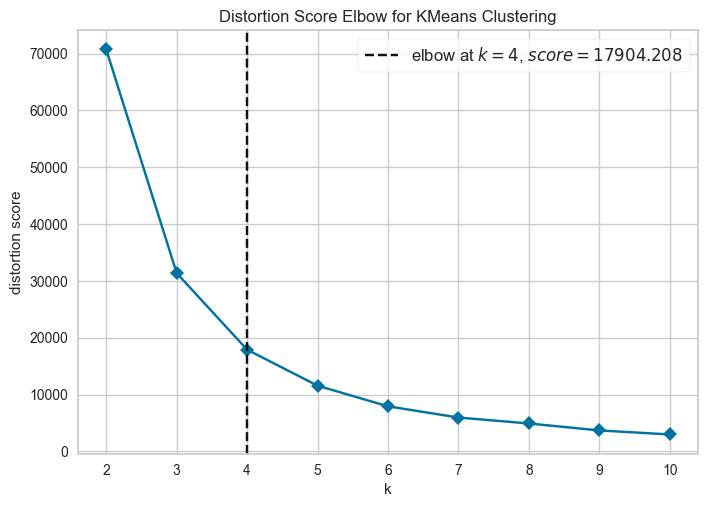

In [12]:
# Plot Elbow untuk membantu menentukan jumlah cluster terbaik
plot_model(kmeans_model, plot='elbow')

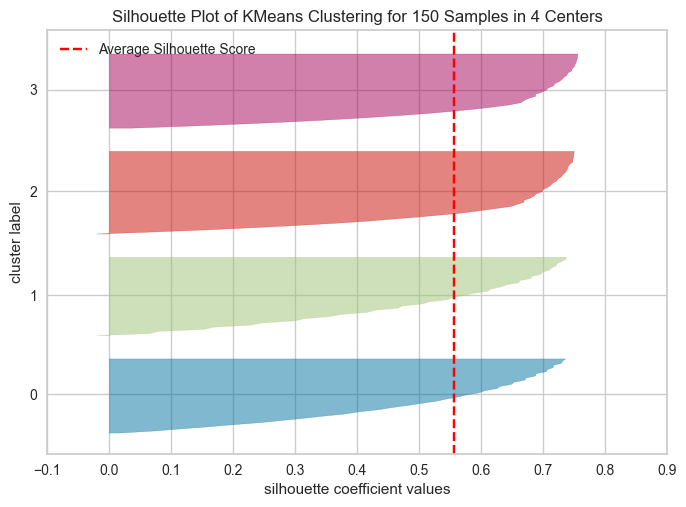

In [13]:
# Plot Silhouette untuk melihat seberapa baik setiap titik data cocok dalam clusternya
plot_model(kmeans_model, plot='silhouette')